<a href="https://colab.research.google.com/github/Mercymerine/Machine_learning2/blob/main/Brain_tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting the datasets**

In [1]:
import pathlib
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 79% 12.0M/15.1M [00:00<00:00, 17.4MB/s]
100% 15.1M/15.1M [00:01<00:00, 14.8MB/s]


In [3]:
input_dir = pathlib.Path('/content/brain-mri-images-for-brain-tumor-detection.zip')

In [4]:
#Unzipping the dataset
zip_ref = zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Lists image files: It uses os.listdir() to grab the filenames of the first 5 images in the specified folder (image_folder).

Opens each image: It opens each image file using PIL (Python Imaging Library), which allows you to load and work with images in Python.

Displays each image: It then uses matplotlib, a popular plotting library, to display the images one by one in a popup window or inline (if you are using a Jupyter Notebook).

In [5]:
!ls brain_tumor_dataset

no  yes


## **Viewing Images**

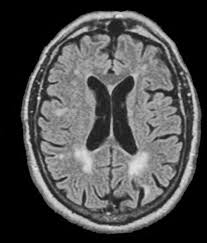

In [6]:
#Viewing each image sample actual picture
from PIL import Image
Image.open('brain_tumor_dataset/no/22 no.jpg')

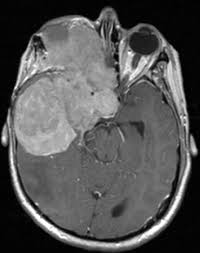

In [7]:
import os
os.listdir('brain_tumor_dataset/yes')

from PIL import Image
Image.open('/content/brain_tumor_dataset/yes/Y106.jpg')

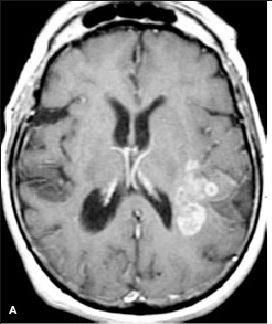

In [8]:
from PIL import Image
Image.open('/content/brain_tumor_dataset/yes/Y111.JPG')

## **Getting the class names**

In [9]:
data_dir = pathlib.Path('/content/brain_tumor_dataset')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['no' 'yes']


## **Splitting the dataset using os and shutil**

In [10]:
import shutil
from sklearn.model_selection import train_test_split

In [11]:
#Define the source directory containing images and destination directories
source_dir = '/content/brain_tumor_dataset'
train_dir = 'content/train'
val_dir = 'content/val'
test_dir = 'content/test'

#Create train, validation and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Iterate through each class folder
for class_folder in os.listdir(source_dir):
  class_path = os.path.join(source_dir, class_folder)

  #Check if the current item is a directory class
  if os.path.isdir(class_path):

    #List all images for this class
    images = os.listdir(class_path)

    #Split images into train, validation and test datasets
    train_images, test_images = train_test_split(images, test_size = 0.2, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

    #Create subdirectories for this class in train, val and test folders
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    #Copy the images to the respective directories
    for image in train_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_folder, image))
    for image in val_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_folder, image))
    for image in test_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_folder, image))

## **Load the data with ImageDataGenerator**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
#Rescaling the data and applying augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                rotation_range = 40,
                                width_shift_range =0.2,
                                height_shift_range =0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True,
                                validation_split = 0.2)

In [14]:
#Loading the training data
train_data = train_datagen.flow_from_directory('/content/content/train',
                                               target_size = (256, 256),
                                               batch_size = 32,
                                               class_mode = 'categorical',
                                               shuffle = True,
                                               seed = 42
                                               )

Found 202 images belonging to 2 classes.


In [15]:
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
#Loading the validation data
validation_data = valid_datagen.flow_from_directory('/content/content/val',
                                                    target_size = (256, 256),
                                                    batch_size =32,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed=42)

Found 25 images belonging to 2 classes.


## **BUILD THE CNN MODEL**

In [17]:
from tensorflow.keras import layers, models

#Initalize the CNN model
model = models.Sequential()

#Add convolutionn and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Flatten the data for fully connected layers
model.add(layers.Flatten())

#Add dense layers
model.add(layers.Dense(512, activation = 'relu'))

#Output layer
model.add(layers.Dense(2, activation = 'softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Compile the model**

In [18]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## **Train the model**

In [19]:
history = model.fit(train_data,
                    steps_per_epoch = train_data.batch_size,
                    epochs = 20,
                    validation_data = validation_data,
                    validation_steps = validation_data.batch_size)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 7/32 ━━━━━━━━━━━━━━━━━━━━ 22s 903ms/step - accuracy: 0.4504 - loss: 0.9746

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - accuracy: 0.4853 - loss: 0.9178 - val_accuracy: 0.6400 - val_loss: 0.6764
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6053 - loss: 0.6605 - val_accuracy: 0.6400 - val_loss: 0.5683
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6058 - loss: 0.6390 - val_accuracy: 0.7600 - val_loss: 0.5437
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5830 - loss: 0.6603 - val_accuracy: 0.7200 - val_loss: 0.5271
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6443 - loss: 0.6285 - val_accuracy: 0.6000 - val_loss: 0.6131
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6831 - loss: 0.6197 - val_accuracy: 0.6400 - val_loss: 0.6110
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6868 - loss: 0.6218 - val_accuracy: 0.6000 - val_loss: 0.7705
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6902 - loss: 0.6276 - val_accuracy: 0.6000 - val_loss:

# **Visualize Training Perfomance**

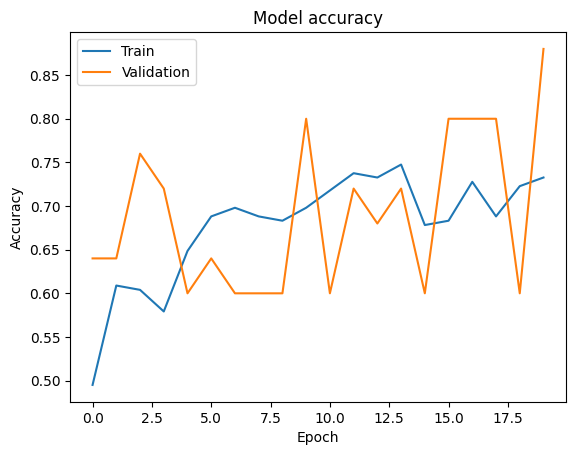

In [20]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

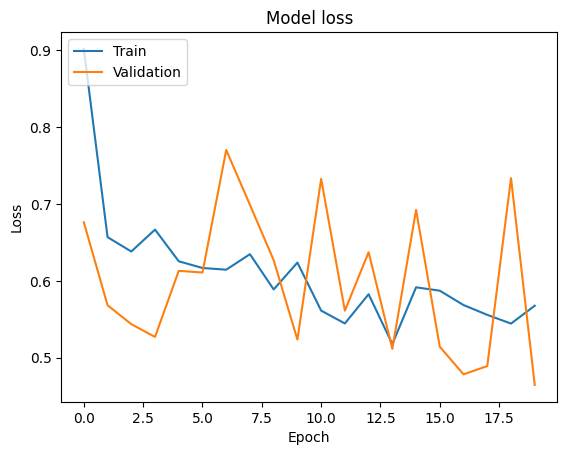

In [21]:
#Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Evaluate the model**


In [22]:
test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory('/content/brain_tumor_dataset',
                                             target_size = (256, 256),
                                             batch_size = 32,
                                             class_mode = 'categorical')

test_loss, test_accuracy = model.evaluate(test_data)
print(f' Test accuracy : {test_accuracy}')

Found 253 images belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.8308 - loss: 27.7324
 Test accuracy : 0.8379446864128113


## **Applying VG16 Pretrained model**

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3),
                   include_top = False,
                   weights = 'imagenet')

for layer in base_model.layers:
  layer.trainable = False

#Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

#Add a fully connected layer
x= layers.Dense(512, activation = 'relu')(x)

#Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

#Add a final sigmoid layer with 1-node for classifcation output
x = layers.Dense(2, activation = 'sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

#Applying vg16 model
vgghist = model.fit(train_data,
                    validation_data=validation_data,
                    epochs =10
                    )





Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - acc: 0.5603 - loss: 1.5728 - val_acc: 0.7600 - val_loss: 0.5854
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - acc: 0.6023 - loss: 0.7894 - val_acc: 0.8000 - val_loss: 0.5368
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - acc: 0.5961 - loss: 0.6989 - val_acc: 0.7200 - val_loss: 0.5405
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - acc: 0.6656 - loss: 0.6607 - val_acc: 0.6400 - val_loss: 0.5909
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - acc: 0.6995 - loss: 0.5955 - val_acc: 0.6400 - val_loss: 0.6447
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - acc: 0.7176 - loss: 0.5586 - val_acc: 0.9200 - val_loss: 0.4778
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - acc: 0.5754 - loss: 0.6734 - val_acc: 0.6000 - val_loss: 0.7302
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - acc: 0.5775 - loss: 0.7274 - val_acc: 0.8000 - val_loss: 0.4684
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - acc: 0.6944 - loss: 0

In [26]:
#Applying it to my test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f' Test accuracy : {test_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - acc: 0.8104 - loss: 1.8693
 Test accuracy : 0.8300395011901855


## **Applying Inception**

In [27]:
#Loading the model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (256, 256, 3), include_top=False, weights='imagenet')

#Compile and fit
for layer in base_model.layers:
  layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

#Add a final sigmoid layer with 2 node for classification output
x = layers.Dense(2, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

inception_history = model.fit(train_data, validation_data=validation_data, epochs=10)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - acc: 0.5920 - loss: 10.4950 - val_acc: 0.6000 - val_loss: 3.1052
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - acc: 0.5794 - loss: 2.4706 - val_acc: 0.6800 - val_loss: 0.4792
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 0.7295 - loss: 0.6230 - val_acc: 0.6800 - val_loss: 0.5065
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - acc: 0.7880 - loss: 0.5941 - val_acc: 0.6800 - val_loss: 0.4607
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - acc: 0.8098 - loss: 0.4112 - val_acc: 0.7200 - val_loss: 0.7188
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 0.7472 - loss: 0.5753 - val_acc: 0.6800 - val_loss: 0.7308
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - acc: 0.7977 - loss: 0.4600 - val_acc: 0.8000 - val_loss: 0.4899
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - acc: 0.7198 - loss: 0.6849 - val_acc: 0.8000 - val_loss: 0.5567
Epoch 9/10
7/7 ━━━━━━